<a href="https://colab.research.google.com/github/Deep-Learning-IGP-TUBS-SoSe2022/2022-Group03/blob/main/Assignments/00-EntryTask_MLP_FashionMNIST/falinker/Simple_MLP_falinker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Course**: Deep Learning | Entry Task: MLP on UCM

[<img align="right" width="400" height="100" src="https://www.tu-braunschweig.de/typo3conf/ext/tu_braunschweig/Resources/Public/Images/Logos/tu_braunschweig_logo.svg">](https://www.tu-braunschweig.de/en/) 

[Mehdi Maboudi](https://www.tu-braunschweig.de/en/igp/staff/mehdi-maboudi) \([m.maboudi@tu-bs.de](m.maboudi@tu-bs.de)) and [Pedro Achanccaray](https://www.tu-braunschweig.de/en/igp/staff/pedro-diaz) (p.diaz@tu-bs.de)

[Technical University of Braunschweig](https://www.tu-braunschweig.de/en/)  
[Institute of Geodesy and Photogrammetry](https://www.tu-braunschweig.de/igp) 


Student: Fabian Linkerhägner

#-------------------------------------------------------------------------------

## Import required packages

In [1]:
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from torchvision.transforms import ToTensor, Resize, ToPILImage
from torchvision.transforms.functional import pil_to_tensor

from PIL import Image
from datetime import datetime

import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

#-------------------------------------------------------------------------------

## Define helper functions

In [2]:
# helper function to show an image
def matplotlib_imshow( img, mean, std, one_channel=False ):
    
    if one_channel:

        img = img.mean( dim=0 )

    img   = img.cpu() / std + mean     # unnormalize
    npimg = img.numpy()
    
    if one_channel:
        
        plt.imshow( npimg, cmap="Greys" )
    
    else:

        plt.imshow( np.transpose( npimg, (1, 2, 0) ) )
  
# TensorBoard SummaryWriter
writer = SummaryWriter('runs/ucm_experiment_1')

#-------------------------------------------------------------------------------

## Setup runtime environment / device

In [3]:
gpu_info = !nvidia-smi

gpu_info = '\n'.join( gpu_info )

if gpu_info.find( 'failed' ) >= 0:

  print( 'Not connected to a GPU' )
  
else:

  print( gpu_info )

Thu Jun 23 14:24:38 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
device = torch.device( "cuda:0" if torch.cuda.is_available() else "cpu" )

In [5]:
from psutil import virtual_memory

ram_gb = virtual_memory().total / 1e9

print( 'Your runtime has {:.1f} gigabytes of available RAM\n'.format( ram_gb ) ) 

if ram_gb < 20:

  print( 'Not using a high-RAM runtime' )
  
else:

  print( 'You are using a high-RAM runtime!' )

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


#-------------------------------------------------------------------------------

Mount Google Drive and set ROOT folder

In [7]:
from google.colab import drive
drive.mount( '/content/drive', force_remount=True )

Mounted at /content/drive


In [8]:
ROOT= "/content/drive/MyDrive/DeepLearning"

#-------------------------------------------------------------------------------

## Create class for loading custom datasets

In [9]:
class CustomImageDataset( Dataset ):

    def __init__( 
                  self, annotations_file,
                  img_dir, 
                  transform=None,
                  target_transform=None, 
                 ):
       
        self.img_labels = pd.read_csv( annotations_file )
        self.img_dir    = img_dir
        self.transform  = transform
        self.target_transform = target_transform

    def __len__( self ):
        
        return len( self.img_labels )

    def __getitem__( self, idx ):
        
        img_path = os.path.join( self.img_dir, self.img_labels.iloc[ idx, 0 ] )
        image    = Image.open( img_path )
        label    = self.img_labels.iloc[ idx, 1 ]
        
        if self.transform:
            
            image = self.transform( image )
        
        if self.target_transform:
            
            label = self.target_transform( label )
        
        return image, label

## Set paths to custom dataset

In [14]:
# Path/folder where your datasets are located
DATASETS_LOCATION = "datasets"

# Path to folder containing images
path_img_dir = os.path.join( 
                              ROOT, DATASETS_LOCATION,
                              "ucm/UCMerced_LandUse/Images" 
                            )

# Path to .csv containing image labels
path_annotations_csv = os.path.join( 
                                      ROOT, DATASETS_LOCATION,
                                      "ucm/UCMerced_LandUse/annotations.csv" 
                                    )

print( f"path to images:\t\t{ path_img_dir }" )
print( f"path to label .csv:\t{ path_annotations_csv }" )

path to images:		/content/drive/MyDrive/DeepLearning/datasets/ucm/UCMerced_LandUse/Images
path to label .csv:	/content/drive/MyDrive/DeepLearning/datasets/ucm/UCMerced_LandUse/annotations.csv


## Define a class that will apply the shuffling to the images in the dataset

In [15]:
class CustomTransform(object):

    """
    """

    def __init__( self ):
      
      self.shuffle_idx = torch.randperm( 
                                          n=( 28 * 28 ),
                                          generator=torch.manual_seed( 42 ) 
                                        )

    def __call__( self, sample ):
      
      img = pil_to_tensor(sample)

      img = img.view( -1 )[ self.shuffle_idx ].reshape( 1, 28, 28 ).numpy()

      img = Image.fromarray(img[0])

      return img

    def __repr__( self ) -> str:

      return f"{self.__class__.__name__}()"
 

## Define transformation without knowing the normalization values


In [51]:
# Define the desired image size
IMG_SIZE = 256

# Define the transformation prior to normalization
transform_no_norm  = transforms.Compose([
                                          transforms.ToTensor(),
                                          transforms.Resize( IMG_SIZE ),
                                          transforms.CenterCrop( IMG_SIZE ),
                                        ])

## Load / download the dataset

In [21]:
# Download the non-normalized dataset
data_not_normed = CustomImageDataset(
                                      path_annotations_csv, 
                                      path_img_dir,
                                      transform=transform_no_norm,
                                    )

print( f"UCM dataset was loaded from local disk." )

# Create DataLoader for non-normalized dataset
loader = DataLoader(
                      data_not_normed, 
                      batch_size=len( data_not_normed ),
                      num_workers=2,
                    )

UCM dataset was loaded from local disk.


## Calculate mean and std of the dataset (3 channels) for normalization

In [24]:
ALREADY_CALCULATED = True # Set true if you do not want to calculate mean / std again

# If mean and std are not yet calculated, calculate them now
if not ALREADY_CALCULATED:

  # Iterate over whole non-normalized dataset
  total_data_not_normed = next( iter( loader ) )

  # Calculate mean value (1 channel)
  mean = [
           torch.mean( total_data_not_normed[ 0 ][ :, 0 ] ),
           torch.mean( total_data_not_normed[ 0 ][ :, 1 ] ),
           torch.mean( total_data_not_normed[ 0 ][ :, 2 ] ),
          ] 

  # Calculate std (1 channel)
  std = [
           torch.std( total_data_not_normed[ 0 ][ :, 0 ] ),
           torch.std( total_data_not_normed[ 0 ][ :, 1 ] ),
           torch.std( total_data_not_normed[ 0 ][ :, 2 ] ),
          ] 

# otherwise, use values from previous calculations
else:

  # from previous calculations
  mean =[torch.tensor(0.4843), torch.tensor(0.4902), torch.tensor(0.4506)]
  std = [torch.tensor(0.2179), torch.tensor(0.2019), torch.tensor(0.1957)]

print( f"mean:\t{ mean }" )
print( f"std:\t{ std }" )

mean:	[tensor(0.4843), tensor(0.4902), tensor(0.4506)]
std:	[tensor(0.2179), tensor(0.2019), tensor(0.1957)]


## Define transformation knowing the normalization values

In [25]:
# Transformation that will be applied to the dataset
transform_w_norm = transforms.Compose([
                                          transforms.ToTensor(),
                                          transforms.Resize( IMG_SIZE ),
                                          transforms.CenterCrop( IMG_SIZE ),
                                          transforms.Normalize(
                                                                mean,
                                                                std
                                                                ),
                                        ]) 

## Load the normalized dataset 

In [26]:
# load the normalized dataset
dataset = CustomImageDataset(
                              path_annotations_csv,
                              path_img_dir,
                              transform=transform_w_norm,
                              ) 

print( f"UCM datasets was loaded from disk." )

UCM datasets was loaded from disk.


## Split dataset into train, validation and test subsets

In [27]:
# Percentages of validation and test subset
TEST_RATIO  = 0.2
VALID_RATIO = 0.2

# Total number of data samples in the dataset
data_samples = len(dataset)

# Number of test samples
test_samples = int(data_samples * TEST_RATIO)

# Percentage of test data
test_perc = (test_samples / data_samples) * 100

# Number of for training
training_samples = data_samples - test_samples

# Percentage of training data (train + validation)
training_perc = (training_samples / data_samples) * 100

# Number of validation samples
valid_samples = int(training_samples * VALID_RATIO)

# Percentage of validation data
val_perc = (valid_samples / training_samples) * 100

# Number of train samples (train + validation)
train_samples = training_samples - valid_samples

# Percentage of train data
train_perc = (train_samples / training_samples) * 100

print( f"dataset samples:\t{data_samples}\n")
print( f"training samples:\t{training_samples}\t-- {training_perc:.0f} %")
print( f"test samples:\t\t{test_samples:}\t-- {test_perc:.0f} %\n")
print( f"train samples:\t\t{train_samples}\t-- {train_perc:.0f} %")
print( f"validation samples:\t{valid_samples}\t-- {val_perc:.0f} %\n")

"""
~ generator=torch.Generator().manual_seed(42)

-> used to get reproducible results while splitting datasets
"""

# Split total data into training and test subsets
training_data, test_data = random_split(
                                          dataset,
                                          [training_samples, test_samples],
                                          generator=torch.Generator().manual_seed(42)
                                        )

# Split training data into train and validation subsets
train_data, valid_data = random_split(
                                        training_data, 
                                        [train_samples, valid_samples],
                                        generator=torch.Generator().manual_seed(42)
                                      )

dataset samples:	2099

training samples:	1680	-- 80 %
test samples:		419	-- 20 %

train samples:		1344	-- 80 %
validation samples:	336	-- 20 %



## Visualize non-shuffled dataset

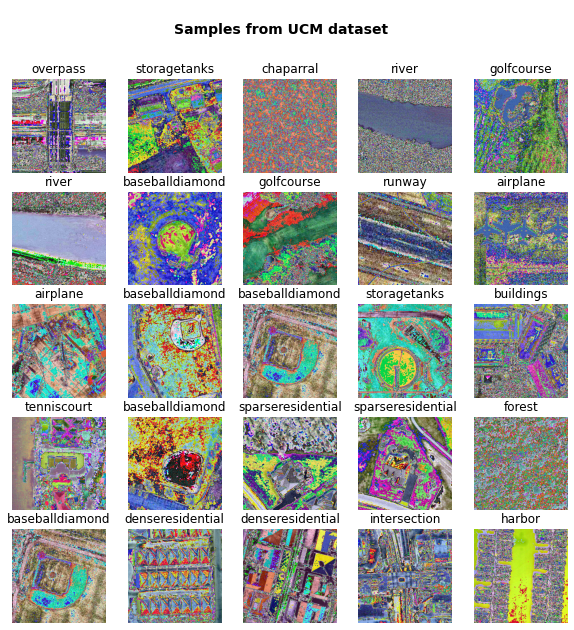

In [38]:
labels_map = {
                0: "tenniscourt",
                1: "baseballdiamond",
                2: "beach",
                3: "buildings",
                4: "chaparral",
                5: "denseresidential",
                6: "freeway",
                7: "golfcourse",
                8: "harbor",
                9: "intersection",
                10: "mediumresidential",
                11: "mobilehomepark",
                12: "overpass",
                13: "parkinglot",
                14: "river",
                15: "runway",
                16: "sparseresidential",
                17: "storagetanks",
                18: "airplane",
                19: "forest",
                20: "agricultural"
            }

figure = plt.figure( figsize=( 10, 10 ) )
figure.suptitle( "\nSamples from UCM dataset", fontsize=14, fontweight="bold" )

cols, rows = 5, 5

for i in range( 1, cols * rows + 1 ):

    sample_idx = torch.randint( len( train_data ), size=(1, ) ).item()
    img, label = training_data[ sample_idx ]

    img = img.permute( 1, 2, 0 ).numpy()

    figure.add_subplot( rows, cols, i )

    plt.title( labels_map[ label ] )
    plt.axis( "off" )
    plt.imshow( ( img * 255 ).astype(np.uint8 ) )

plt.show()

## Setup DataLoaders

In [39]:
# Set the batch size
BATCH_SIZE = 32

# Create dataloaders for train, validation and test data
train_dataloader = DataLoader( train_data, batch_size=BATCH_SIZE, shuffle=True )
training_steps   = len( train_dataloader )

validation_dataloader = DataLoader( valid_data, batch_size=BATCH_SIZE, shuffle=True )
validation_steps      = len( validation_dataloader )

test_dataloader = DataLoader( test_data, batch_size=BATCH_SIZE, shuffle=True )
test_steps      = len( test_dataloader )

#-------------------------------------------------------------------------------

## Define MLP architecture

In [79]:
# Define the model architecture
class MLP(nn.Module):

  def __init__(self):
      
    super( MLP, self ).__init__()

    self.input_shape = 256 * 256 * 3
    self.output_classes = 21

    self.mlp = nn.Sequential(   
                                nn.Flatten(),
                                nn.Linear( self.input_shape, 1000),
                                nn.BatchNorm1d(1000),
                                nn.ReLU(),
                                nn.Linear( 1000 , 500),
                                nn.BatchNorm1d(500),
                                nn.ReLU(),
                                nn.Linear( 500 , 200),
                                nn.BatchNorm1d(200),
                                nn.ReLU(),
                                nn.Linear( 200 , 100),
                                nn.BatchNorm1d(100),
                                nn.ReLU(),
                                nn.Linear( 100 , 50),
                                nn.Dropout(0.2),
                                nn.BatchNorm1d(50),
                                nn.ReLU(),
                                nn.Linear( 50 , self.output_classes),
                            )

  def forward( self, x ):

    out = self.mlp( x )

    return out

In [80]:
LEARNING_RATE = 1e-3
# MOMENTUM = 0.9 # not used for ADAM optimizer but for SGD

model = MLP().to( device )

print( f"Current MLP used:\n\n { model }" )

total_params     = sum( p.numel() for p in model.parameters() )
trainable_params = sum( p.numel() for p in model.parameters() if p.requires_grad )

print( f"\nTotal model parameters:\t{ total_params }" )
print( f"Trainable:\t\t{ trainable_params }" )
print( f"Non-trainable:\t\t{ (total_params - trainable_params) }" )

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    
                              model.parameters(),
                              lr=LEARNING_RATE,
                            
                            )

Current MLP used:

 MLP(
  (mlp): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=196608, out_features=1000, bias=True)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Linear(in_features=1000, out_features=500, bias=True)
    (5): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Linear(in_features=500, out_features=200, bias=True)
    (8): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Linear(in_features=200, out_features=100, bias=True)
    (11): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): Linear(in_features=100, out_features=50, bias=True)
    (14): Dropout(p=0.2, inplace=False)
    (15): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (16): ReLU()
    (17): Linear(in_fe

#-------------------------------------------------------------------------------

## Define function to train one epoch

In [81]:
def train_one_epoch( epoch_idx, train_loader ):

  running_loss = 0.
  avg_loss     = 0.

  total   = 0
  correct = 0

  for i, data in enumerate( train_loader ):

    inputs, labels = data
    inputs, labels = inputs.cuda(), labels.cuda()

    optimizer.zero_grad()

    outputs = model(inputs)

    loss = loss_fn( outputs, labels )
    loss.backward()

    optimizer.step()

    running_loss += loss.item()

    _, predicted = outputs.max( 1 )
    total       += labels.size( 0 )
    correct     += predicted.eq( labels ).sum().item()

  avg_loss = running_loss / ( i + 1 )
  acc      = 100. * correct / total

  print( f"Epoch:\t{ epoch_idx } -- training:\n\tloss:\t{avg_loss:.3f}\n\tacc:\t{acc:.2f}" )

  return avg_loss, acc

## Define function to validate one epoch

In [82]:
def valid_one_epoch( epoch_idx, validation_loader ):

  running_vloss = 0.
  avg_vloss     = 0.

  vtotal   = 0
  vcorrect = 0
  
  for i, vdata in enumerate( validation_loader ):

    vinputs, vlabels = vdata
    vinputs, vlabels = vinputs.cuda(), vlabels.cuda()
    
    voutputs = model( vinputs )

    vloss = loss_fn( voutputs, vlabels )

    running_vloss += vloss.item()

    _, predicted = voutputs.max( 1 )
    vtotal      += vlabels.size( 0 )
    vcorrect    += predicted.eq( vlabels ).sum().item()
  
  avg_vloss = running_vloss / ( i + 1 )
  vacc      = 100. * vcorrect / vtotal
  
  print(f"Epoch:\t{epoch_idx + 1} -- validation:\n\tloss:\t{avg_vloss:.3f}\n\tacc:\t{vacc:.2f}")

  return avg_vloss, vacc


## Train model over all epochs

In [83]:
# (ROOT +) Path where model should be stored
PATH_MODEL = "assignments/MLP_shuffledFeatures"

# Define the number of training epochs
EPOCHS = 20

# Set timestamp for identifying model later
timestamp = datetime.now().strftime( '%Y%m%d_%H%M&S' )

# Get starting time of training
since = int( round( time.time() ) )

# Current epoch number
epoch_number = 0

# Current best validation loss (default: 1.000.000)
best_vloss = 1_000_000.

# Current best validation accuracy (default: 0.0)
best_vacc = 0.

# Reserve memory to track training progress
hist = {
          "train_loss" : [],
          "train_acc"  : [],
          "valid_loss" : [],
          "valid_acc"  : []
        }

# Do the actual training
for epoch in range(EPOCHS):

  # Set model to training mode
  model.train()

  # Calculate training loss and accuracy for current epoch
  train_loss, train_acc = train_one_epoch(epoch, train_dataloader)
  
  # Save training loss and accuracy to history
  hist[ "train_loss" ].append( train_loss )
  hist[ "train_acc" ].append( train_acc )
  
  # Set model to evaluation mode
  model.eval()

  # Calculate validation loss and accuracy for current epoch
  valid_loss, valid_acc = valid_one_epoch(epoch, validation_dataloader)
  
  hist[ "valid_loss" ].append( valid_loss )
  hist[ "valid_acc" ].append( valid_acc )
  
  # If validation loss decreased / validation accuary improved, save new model
  if valid_loss < best_vloss:

    print( f"Valid loss decreased from {best_vloss:.3f} to {valid_loss:.3f}." )
    print( f"Valid acc increased from {best_vacc:.3f} % to {valid_acc:.3f} %." )

    # Update best_vloss
    best_vloss = valid_loss

    # Update best_vacc
    best_vacc = valid_acc

    # Save improved model using timestampe
    model_path = os.path.join(ROOT, PATH_MODEL, f"model_{ timestamp }_{ epoch }")
    torch.save( model.state_dict(), model_path )

# Save amount of time passed since training started
time_elapsed = int( round( time.time() ) ) - since

print( f"Training took:\t{ time_elapsed } seconds." )
print( f"Average time per epoch:\t{ time_elapsed / EPOCHS }" )

Epoch:	0 -- training:
	loss:	2.917
	acc:	13.39
Epoch:	0 -- validation:
	loss:	2.815
	acc:	18.15
Valid loss decreased from 1000000.000 to 2.815.
Valid acc increased from 0.000 % to 18.155 %.
Epoch:	1 -- training:
	loss:	2.682
	acc:	22.32
Epoch:	1 -- validation:
	loss:	2.680
	acc:	21.43
Valid loss decreased from 2.815 to 2.680.
Valid acc increased from 18.155 % to 21.429 %.
Epoch:	2 -- training:
	loss:	2.509
	acc:	27.60
Epoch:	2 -- validation:
	loss:	2.525
	acc:	28.27
Valid loss decreased from 2.680 to 2.525.
Valid acc increased from 21.429 % to 28.274 %.
Epoch:	3 -- training:
	loss:	2.370
	acc:	31.18
Epoch:	3 -- validation:
	loss:	2.443
	acc:	30.36
Valid loss decreased from 2.525 to 2.443.
Valid acc increased from 28.274 % to 30.357 %.
Epoch:	4 -- training:
	loss:	2.193
	acc:	36.31
Epoch:	4 -- validation:
	loss:	2.321
	acc:	28.87
Valid loss decreased from 2.443 to 2.321.
Valid acc increased from 30.357 % to 28.869 %.
Epoch:	5 -- training:
	loss:	1.977
	acc:	42.63
Epoch:	5 -- validation:

#-------------------------------------------------------------------------------

## Visualizing training loss (conservative way)

Text(0.5, 1.0, 'training progress (loss over the epochs)')

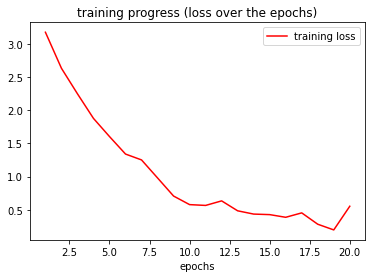

In [73]:
# visualize the training progress (loss)
x_axis_dim = np.linspace( 1, EPOCHS, EPOCHS )

plt.plot( x_axis_dim, hist[ "train_loss" ], color="r", label="training loss" )

plt.legend()
plt.xlabel( "epochs" )
plt.title( "training progress (loss over the epochs)" )

## Visualizing training accuracy (conservative way)

Text(0.5, 1.0, 'training progress (accuracy over the epochs)')

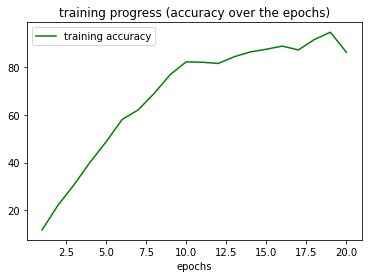

In [68]:
# visualize the training progress (accuracy)
x_axis_dim = np.linspace( 1, EPOCHS, EPOCHS )

plt.plot( x_axis_dim, hist[ "train_acc" ], color='g', label='training accuracy' )

plt.legend()
plt.xlabel( "epochs" )
plt.title( "training progress (accuracy over the epochs)" ) 

## Visualizing training loss (conservative way)

Text(0.5, 1.0, 'validation progress (loss over the epochs)')

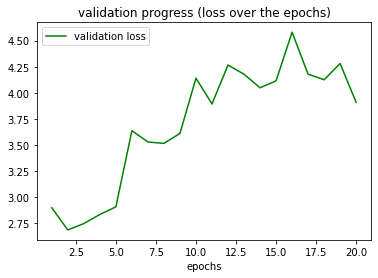

In [69]:
# visualize the validation progress (loss)
x_axis_dim = np.linspace( 1, EPOCHS, EPOCHS )

plt.plot( x_axis_dim, hist[ "valid_loss" ],  color='g',      label='validation loss' )

plt.legend()
plt.xlabel( "epochs" )
plt.title( "validation progress (loss over the epochs)" )

## Visualizing validation accuracy (conservative way)

Text(0.5, 1.0, 'validation progress (accuracy over the epochs)')

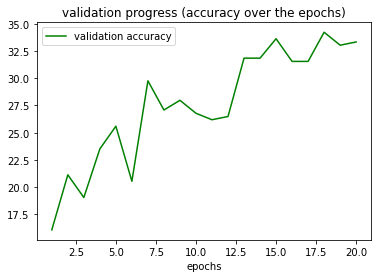

In [70]:
# visualize the validation progress (accuracy)
x_axis_dim = np.linspace( 1, EPOCHS, EPOCHS )

plt.plot( x_axis_dim, hist[ "valid_acc" ], color='g', label='validation accuracy' )

plt.legend()
plt.xlabel( "epochs" )
plt.title( "validation progress (accuracy over the epochs)" )

#-------------------------------------------------------------------------------

## Testing the model on the test data

In [71]:
def test_loop( test_loader, model, loss_fn ):

    model.eval()

    size = len( test_loader.dataset )
    num_batches = len( test_loader )

    test_loss, correct = 0, 0

    with torch.no_grad():

        for X, y in test_loader:
            
            X, y = X.to( device ), y.to( device )
            pred = model( X )

            test_loss += loss_fn(pred, y).item()
            correct   += ( pred.argmax( 1 ) == y ).type( torch.float ).sum().item()

    test_loss /= num_batches
    correct   /= size

    print( f"Test Error: Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n" )

## Visualize sample from test data

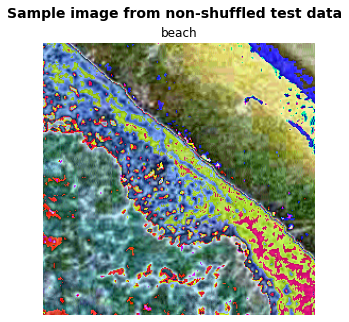

In [84]:
sample_idx = torch.randint( len( test_data ), size=( 1, ) ).item()

img, label = test_data[ sample_idx ]

img = img.permute( 1, 2, 0 ).numpy()

figure = plt.figure( figsize=( 5, 5 ) )
figure.suptitle( "Sample image from non-shuffled test data\n", fontsize=14, fontweight="bold" )

figure.add_subplot( 1, 1, 1 )

plt.axis( "off" )

plt.title( labels_map[ label ] )

plt.imshow( ( img * 255 ).astype( np.uint8 ) )
plt.show()

## Testing model

In [86]:
since = int( round( time.time() ) )

test_loop( test_dataloader, model, loss_fn )

time_elapsed = int( round(time.time() ) ) - since

print( f"Testing took:\t{time_elapsed} seconds." )

Test Error: Accuracy: 35.1%, Avg loss: 2.535095 

Testing took:	2 seconds.


#-------------------------------------------------------------------------------

## Visualize training progress using TensorBoard

#-------------------------------------------------------------------------------